In [2]:
from PIL import Image
import glob
from scipy.io import savemat, loadmat 
from IPython.display import display, clear_output
import pandas as pd
import numpy as np
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import normalized_mutual_info_score, confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

Find actual cluster types and ground truth labels. E.g. Area3 has 6 different rooms as follows;

{'WC', 'conferenceRoom', 'hallway', 'lounge', 'office', 'storage'}

In [3]:
def find_ground_truth_clusters_and_labels():
    path = "C:\\Users\\ustundag\\GitHub\\2D-3D-Semantics\\area_3\\data\\rgb\\*.png"
    labels = []

    for path in glob.glob(path):
        s = path.split('_')
        room = s[3]
        labels.append(str(room))
    
    labels = [l.replace('WC'            , '0') for l in labels]
    labels = [l.replace('conferenceRoom', '1') for l in labels]
    labels = [l.replace('hallway'       , '2') for l in labels]
    labels = [l.replace('lounge'        , '3') for l in labels]
    labels = [l.replace('office'        , '4') for l in labels]
    labels = [l.replace('storage'       , '5') for l in labels]

    return np.asarray(list(map(int, labels)), dtype=np.int64)

In [4]:
def get_room_type(i):
    if i == 0: return 'WC'
    if i == 1: return 'conferenceRoom'
    if i == 2: return 'hallway'
    if i == 3: return 'lounge'
    if i == 4: return 'office'
    if i == 5: return 'storage'

In [5]:
# Assign ground truth labels
labels_gt = find_ground_truth_clusters_and_labels();

A function to save images as numpy array to reduce computational cost by converting to grayscale and resizing.

In [6]:
def save_images():
    path = "C:\\Users\\ustundag\\GitHub\\2D-3D-Semantics\\area_3\\data\\rgb\\*.png"
    images = []
    for path in glob.glob(path):
        clear_output(wait=True)
        img = Image.open(path).convert('L')
        img = np.array(img.resize((90, 90), Image.NEAREST))/255
        images.append(img.flatten())
        display(str(len(images)) + " / 3704")

    savemat('noXYZ_area_3_no_xyz_rgb_90x90.mat', {'rgb': np.array(images)})

In [7]:
mat = loadmat("C:\\Users\\ustundag\\GitHub\\2D-3D-Semantics\\noXYZ_area_3_no_xyz_data_rgb_90x90.mat")
images = mat["rgb"]

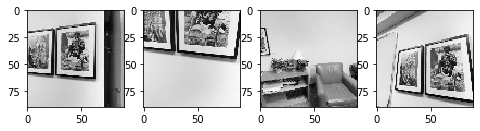

In [8]:
plt.figure(figsize=(8, 8))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow(images[i].reshape([90, 90]), cmap='gray')

### PCA Analysis
We see that the first 3 components have huge impact on images, then then second 3 components follow them.

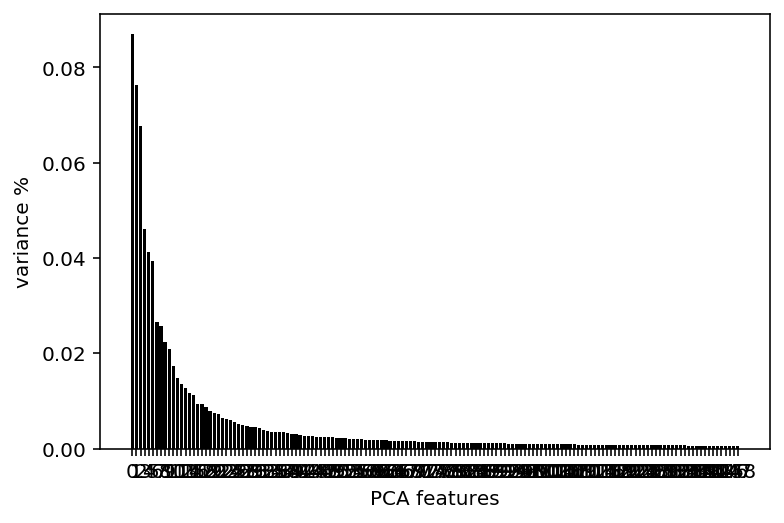

In [9]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, normalize
%config InlineBackend.figure_format='retina'

# Standardize the data to have a mean of ~0 and a variance of 1
X = StandardScaler().fit_transform(images)
X = normalize(X)

# Create a PCA instance
#pca = PCA(n_components=3) # DBSCAN finds only 1 cluster with 3!
pca = PCA(.80) # DBSCAN finds 6 cluster with 0.8!
PCA_components = pca.fit_transform(X)
# Plot the explained variances
# pca has 149 components
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
# Save components as a DataFrame
PCA_components = pd.DataFrame(PCA_components)

### KMEANS Analysis
Determining the best number of clusters; So, 4 is the elbow point for cluster numbers. Maybe 5 or even 6?

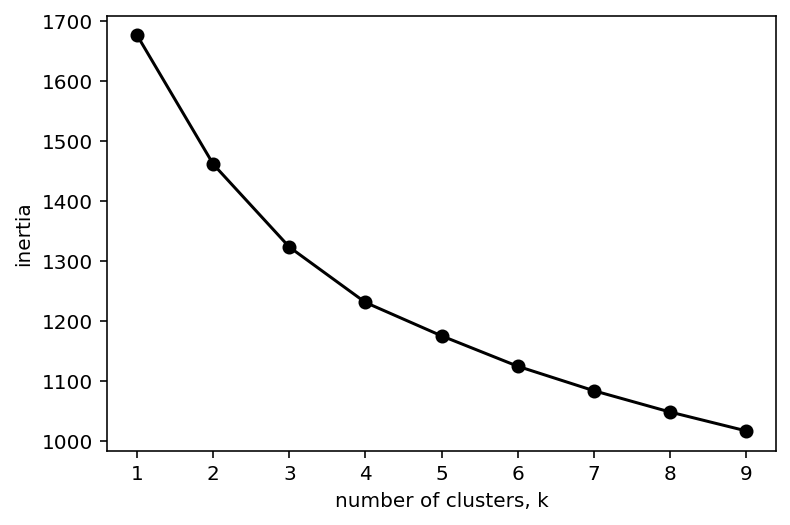

In [10]:
from sklearn.cluster import KMeans

ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    # Fit model to first 10 components
    model.fit(PCA_components.iloc[:,:10])
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

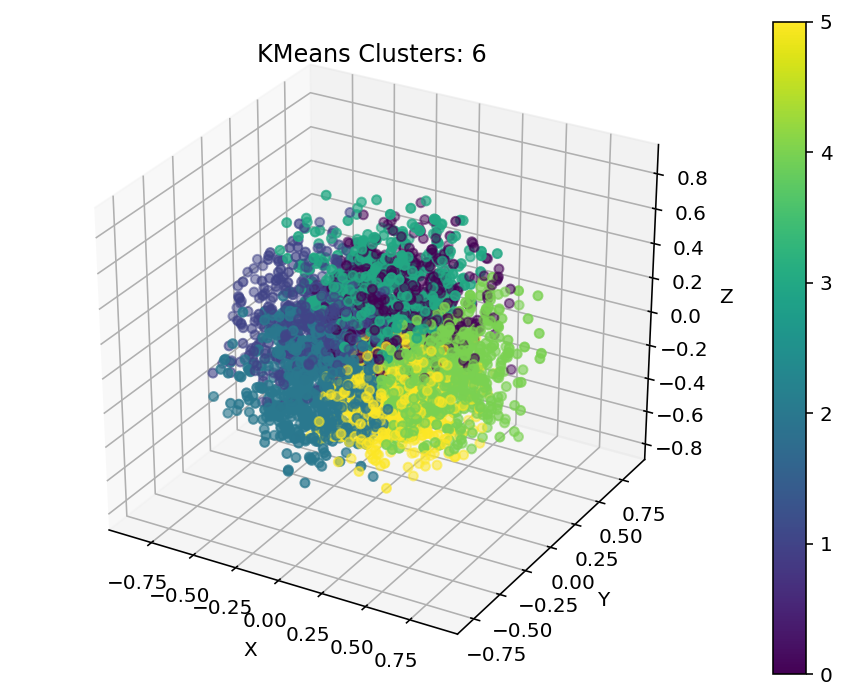

In [11]:
# Apply kmeans and plot 3D
n_clusters = 6
kmeans = KMeans(n_clusters).fit(PCA_components)
labels_kmeans = kmeans.labels_

fig = plt.figure(1, figsize=(8, 6))
ax  = fig.add_subplot(111, projection='3d')
axs = ax.scatter(PCA_components[0],
                 PCA_components[1], 
                 PCA_components[2], 
                 c=labels_kmeans.astype(np.float))

fig.colorbar(axs)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title("KMeans Clusters: " + str(n_clusters))
ax.dist = 10

plt.show()

In [12]:
normalized_mutual_info_score(labels_gt, labels_kmeans)

c:\python368-64\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


0.052391200199169596

### DBSCAN Analysis
Apply DBSCAN and plot 3D. It finds 6 clusters with eps=0.75, min_samples=14. 

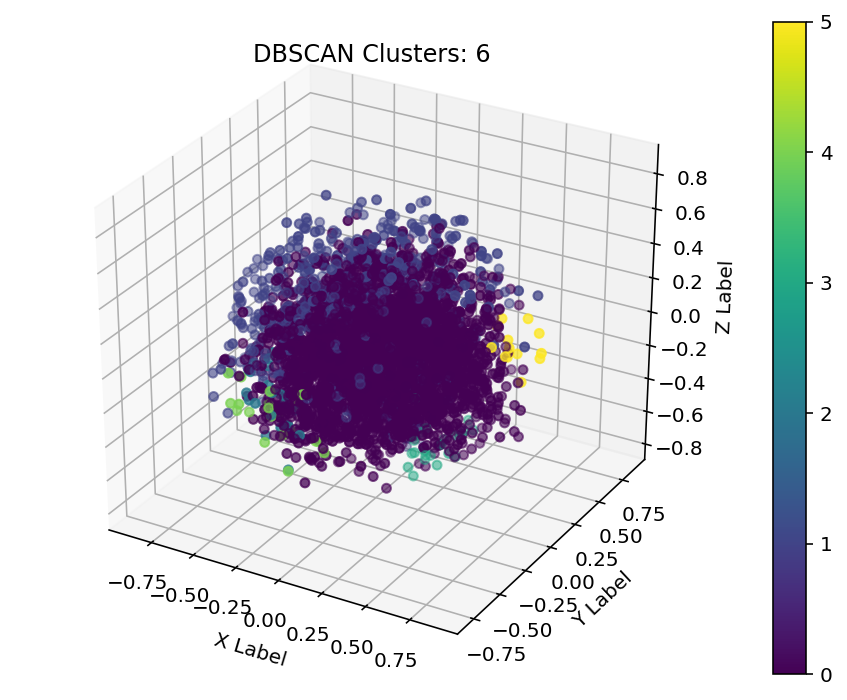

In [73]:
from sklearn.cluster import DBSCAN

# DBSCAN finds 6 clusters with PCA(.80), eps=0.75, min_samples=14
dbs = DBSCAN(eps=0.75, min_samples=14)
labels_dbscan = dbs.fit_predict(PCA_components)+1

fig = plt.figure(1, figsize=(8, 6))
ax  = fig.add_subplot(111, projection='3d')
axs = ax.scatter(PCA_components[0],
                 PCA_components[1],
                 PCA_components[2],
                 c=labels_dbscan.astype(np.float))

fig.colorbar(axs)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.set_title("DBSCAN Clusters: " + str(len(set(labels_dbscan))))
ax.dist = 10

plt.show()

### Distribute images to each cluster folder 

In [14]:
import matplotlib
import os

def create_separate_cluster_folders():
    #Project lower dimension data onto original features
    approximation = pca.inverse_transform(PCA_components)
    #Approximation is 5000x1024
    print("approximation.shape:", approximation.shape)
    #Reshape approximation and X_norm to 3704x90x90 to see diff.
    approximation = approximation.reshape(-1, 90, 90)
    X_r = X.reshape(-1, 90, 90)

    for i in range(len(labels)):
        path = "cluster_" + str(labels[i])
        if not os.path.exists(path):
            os.mkdir(path)
        matplotlib.image.imsave(os.path.join(path, str(i) + '.png'), X_r[i], cmap='gray')

def create_one_folder_with_cluster_names():
    path = 'all_clusters'
    os.mkdir(path)
    for i in range(len(labels)):
        matplotlib.image.imsave(os.path.join(path, 'cluster_' + str(labels[i]) +'_img'+ str(i) + '.png'), X_norm[i], cmap='gray')
    

In [20]:
normalized_mutual_info_score(labels_gt, labels_dbscan)

c:\python368-64\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


0.024930427687004993